In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 

import matplotlib.pyplot as plt 

from kmodes.kmodes import KModes

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix


In [2]:
cardio_df = pd.read_csv("data/cardio.csv",sep=";")
cardio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [3]:
#removing Outliers
# Removing the weights and heights, that fall below 2.5% or above 97.5% of a given range.
cardio_df.drop(cardio_df[(cardio_df['height'] > cardio_df['height'].quantile(0.975)) | (cardio_df['height'] < cardio_df['height'].quantile(0.025))].index,inplace=True)
cardio_df.drop(cardio_df[(cardio_df['weight'] > cardio_df['weight'].quantile(0.975)) | (cardio_df['weight'] < cardio_df['weight'].quantile(0.025))].index,inplace=True)

In [4]:
#In some cases diastolic pressure is higher than systolic, which is also  incorrect. How many records are inaccurate in terms of blood pressure?
print("Diastolic pressure is higher than systolic one in {0} cases".format(cardio_df[cardio_df['ap_lo']> cardio_df['ap_hi']].shape[0]))

Diastolic pressure is higher than systolic one in 1082 cases


In [5]:
cardio_df.drop(cardio_df[(cardio_df['ap_hi'] > cardio_df['ap_hi'].quantile(0.975)) | (cardio_df['ap_hi'] < cardio_df['ap_hi'].quantile(0.025))].index,inplace=True)
cardio_df.drop(cardio_df[(cardio_df['ap_lo'] > cardio_df['ap_lo'].quantile(0.975)) | (cardio_df['ap_lo'] < cardio_df['ap_lo'].quantile(0.025))].index,inplace=True)

In [6]:
#Data after removing outliers
cardio_df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000
mean,49895.698065,19468.719979,1.347311,164.554854,73.426805,125.770526,81.046307,1.350953,1.220229,0.085631,0.051877,0.803648,0.488228
std,28840.467755,2460.510296,0.476120,6.830174,11.614806,13.761847,8.239157,0.670076,0.567607,0.279820,0.221781,0.397241,0.499866
min,0.000000,10798.000000,1.000000,150.000000,52.000000,100.000000,60.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,24867.500000,17677.250000,1.000000,160.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,49902.500000,19705.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74745.750000,21321.000000,2.000000,169.000000,80.000000,135.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,180.000000,106.000000,163.000000,100.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
# transforming the column AGE(measured in days) for Years
cardio_df['years'] = (cardio_df['age'] / 365).round().astype('int')
cardio_df.drop(['age'], axis='columns', inplace=True)
cardio_df.drop(['id'], axis='columns', inplace=True)

In [8]:
# age_bin in quinquenium 5 years spam
cardio_df['age_bin'] = pd.cut(cardio_df['years'], [0,20,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100], 
                              labels=['0-20', '20-30', '30-35', '35-40','40-45','45-50','50-55','55-60','60-65','65-70','70-75','75-80','80-85','85-90','90-95','95-100'])

In [9]:
# Adding Body Mass Index
cardio_df['bmi'] = cardio_df['weight']/((cardio_df['height']/100)**2)

In [10]:
# transforming the column bmi in Body Mass Index Classes (1 to 6)
rating = []
for row in cardio_df['bmi']:
    if row < 18.5 :    rating.append(1) #UnderWeight
    elif row > 18.5 and row  < 24.9:   rating.append(2)#NormalWeight
    elif row > 24.9 and row < 29.9:  rating.append(3)#OverWeight
    elif row > 29.9 and row < 34.9:  rating.append(4)#ClassObesity_1
    elif row > 34.9 and row < 39.9:  rating.append(5)#ClassObesity_2
    elif row > 39.9 and row < 49.9:  rating.append(6)#ClassObesity_3
    elif row > 49.9:  rating.append('Error')
        
    else:           rating.append('Not_Rated')

In [11]:
# inserting Column
cardio_df['BMI_Class'] = rating

In [12]:
# general distribuition
cardio_df["BMI_Class"].value_counts(normalize=True)

3    0.391773
2    0.361943
4    0.179209
5    0.055801
6    0.009162
1    0.002112
Name: BMI_Class, dtype: float64

In [13]:
# creating a Column for MAP
cardio_df['MAP'] = ((2* cardio_df['ap_lo']) + cardio_df['ap_hi']) / 3

In [14]:
#Creating Classes for MAP
map_values = []
for row in cardio_df['MAP']:
    if row < 69.9:    map_values.append(1) #Low
    elif row > 70 and row  < 79.9:   map_values.append(2)#Normal
    elif row > 79.9 and row < 89.9:  map_values.append(3)#Normal
    elif row > 89.9 and row < 99.9:  map_values.append(4)#Normal
    elif row > 99.9 and row < 109.9:  map_values.append(5)#High
    elif row > 109.9 and row < 119.9:  map_values.append(6)#Normal
    elif row > 119.9:  map_values.append(7)
        
    else:           map_values.append('Not_Rated')

In [15]:
#inserting MAP_Class Column
cardio_df['MAP_Class'] = map_values

In [16]:
# Reordering Columns
cardio_df= cardio_df[["gender","height","weight","bmi","ap_hi","ap_lo","MAP","years","age_bin","BMI_Class","MAP_Class","cholesterol","gluc","smoke","active","cardio"]]
cardio_df.head()

,gender,height,weight,bmi,ap_hi,ap_lo,MAP,years,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,2,168,62.0,21.967120,110,80,90.000000,50,45-50,2,4,1,1,0,1,0
1,1,156,85.0,34.927679,140,90,106.666667,55,50-55,5,5,3,1,0,1,1
2,1,165,64.0,23.507805,130,70,90.000000,52,50-55,2,4,3,1,0,0,1
3,2,169,82.0,28.710479,150,100,116.666667,48,45-50,3,6,1,1,0,1,1
4,1,156,56.0,23.011177,100,60,73.333333,48,45-50,2,2,1,1,0,0,0


In [17]:
# only Categorical Data Columns DataFrame
df_cat = cardio_df[["gender","age_bin","BMI_Class","MAP_Class","cholesterol","gluc","smoke","active","cardio",]]
df_cat.head()

,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,2,45-50,2,4,1,1,0,1,0
1,1,50-55,5,5,3,1,0,1,1
2,1,50-55,2,4,3,1,0,0,1
3,2,45-50,3,6,1,1,0,1,1
4,1,45-50,2,2,1,1,0,0,0


In [18]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_cat = df_cat.apply(le.fit_transform)
df_cat.head()

,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,1,3,1,2,0,0,0,1,0
1,0,4,4,3,2,0,0,1,1
2,0,4,1,2,2,0,0,0,1
3,1,3,2,4,0,0,0,1,1
4,0,3,1,0,0,0,0,0,0


In [19]:
df_male = df_cat.query("gender == 1")
df_female = df_cat.query("gender == 0")

In [20]:
# female data
# Building the model with using K-Mode with "Huang" initialization
km_huang = KModes(n_clusters=2, init = "Huang", n_init = 5, verbose=0)
clusters_huang_1 = km_huang.fit_predict(df_female)
clusters_huang_1

clusters_huang_2 = km_huang.fit_predict(df_male)
clusters_huang_2

array([1, 0, 0, ..., 0, 1, 1], dtype=uint16)

In [21]:
df_female.insert(0,"Cluster", clusters_huang_1, True)

# female DataFrame with Clusters
df_female.head()

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
1,1,0,4,4,3,2,0,0,1,1
2,0,0,4,1,2,2,0,0,0,1
4,0,0,3,1,0,0,0,0,0,0
5,0,0,5,2,2,1,1,0,0,0
6,0,0,6,4,2,2,0,0,1,0


In [22]:
df_male.insert(0, "Cluster", clusters_huang_2, True)

# male DataFrame with Clusters
df_male.head()

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,1,1,3,1,2,0,0,0,1,0
3,0,1,3,2,4,0,0,0,1,1
7,0,1,6,3,3,2,2,0,1,1
11,1,1,4,1,2,0,0,0,1,0
12,1,1,2,1,2,0,0,0,0,0


In [23]:
# replacing cluster column values to merge dataframes after
df_male["Cluster"].replace({0:2, 1:3}, inplace=True)
df_male.head()

C:\Users\Hans\anaconda3\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,3,1,3,1,2,0,0,0,1,0
3,2,1,3,2,4,0,0,0,1,1
7,2,1,6,3,3,2,2,0,1,1
11,3,1,4,1,2,0,0,0,1,0
12,3,1,2,1,2,0,0,0,0,0


In [24]:
# merging female and male data
df_clusters = pd.concat([df_female, df_male], ignore_index=True, sort=False)
df_clusters.head(10)

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,1,0,4,4,3,2,0,0,1,1
1,0,0,4,1,2,2,0,0,0,1
2,0,0,3,1,0,0,0,0,0,0
3,0,0,5,2,2,1,1,0,0,0
4,0,0,6,4,2,2,0,0,1,0
5,0,0,3,2,1,0,0,0,1,0
6,0,0,4,2,0,0,0,0,0,0
7,0,0,6,2,2,0,0,0,1,0
8,0,0,4,3,1,0,0,0,1,0
9,0,0,5,2,2,0,0,0,0,0


In [25]:
# preprocessing
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.naive_bayes import GaussianNB

In [26]:
target_name = 'cardio'
data_target = df_clusters[target_name]
data = df_clusters.drop([target_name], axis=1)

In [27]:
#separate into 30/70%
train, test, target, target_test = train_test_split(data, data_target, test_size=0.3, random_state=0)

In [28]:
#%% split training set to validation set
Xtrain, Xval, Ztrain, Zval = train_test_split(train, target, test_size=0.3, random_state=0)

In [29]:
# Gaussian Naive Bayes
#Training
gaussian = GaussianNB()
gaussian.fit(train, target)
acc_gaussian = round(gaussian.score(train, target) * 100, 2)
acc_gaussian

71.21

In [30]:
#Test
acc_test_gaussian = round(gaussian.score(test, target_test) * 100, 2)
acc_test_gaussian

71.19

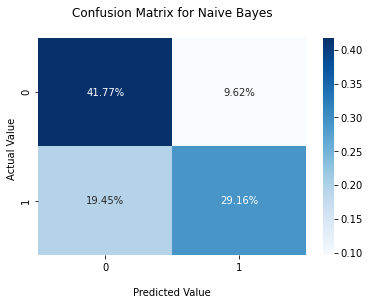

In [31]:
y_pred_gauss = gaussian.predict(Xval)

#Get the confusion matrix 
cf_matrix = confusion_matrix(Zval, y_pred_gauss)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for Naive Bayes\n');
ax.set_xlabel('\nPredicted Value')
ax.set_ylabel('Actual Value ');

## Display the visualization of the Confusion Matrix.
plt.show()

In [32]:
print(classification_report(Zval, y_pred_gauss))

              precision    recall  f1-score   support

           0       0.68      0.81      0.74      6491
           1       0.75      0.60      0.67      6139

    accuracy                           0.71     12630
   macro avg       0.72      0.71      0.70     12630
weighted avg       0.72      0.71      0.71     12630



In [33]:
from sklearn.tree import DecisionTreeClassifier
# Decision Tree Classifier
# Training

decision_tree = DecisionTreeClassifier()
decision_tree.fit(train, target)
acc_decision_tree = round(decision_tree.score(train, target) * 100, 2)
acc_decision_tree

85.73

In [34]:
# Decision Tree Classifier
# Testing

acc_test_decision_tree = round(decision_tree.score(test, target_test) * 100, 2)
acc_test_decision_tree

83.71

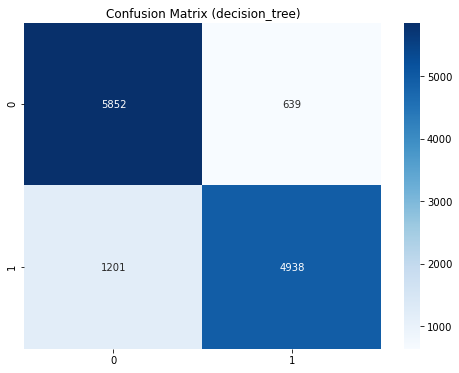

In [35]:
y_pred_dt = decision_tree.predict(Xval)

#Get the confusion matrix 
cf_matrix = confusion_matrix(Zval, y_pred_dt)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(cf_matrix, cmap = 'Blues',annot = True, fmt='d')
ax.set_title('Confusion Matrix (decision_tree)')

## Display the visualization of the Confusion Matrix.
plt.show()

In [36]:
print(classification_report(Zval, y_pred_dt))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      6491
           1       0.89      0.80      0.84      6139

    accuracy                           0.85     12630
   macro avg       0.86      0.85      0.85     12630
weighted avg       0.86      0.85      0.85     12630



In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

# Random Forest
# Training
random_forest = GridSearchCV(estimator=RandomForestClassifier(), param_grid={'n_estimators': [100, 300]}, cv=5).fit(train, target)
random_forest.fit(train, target)
acc_random_forest = round(random_forest.score(train, target) * 100, 2)
print(acc_random_forest,random_forest.best_params_)

85.73 {'n_estimators': 300}


In [38]:
# Random Forest
# Test
acc_test_random_forest = round(random_forest.score(test, target_test) * 100, 2)
acc_test_random_forest

83.99

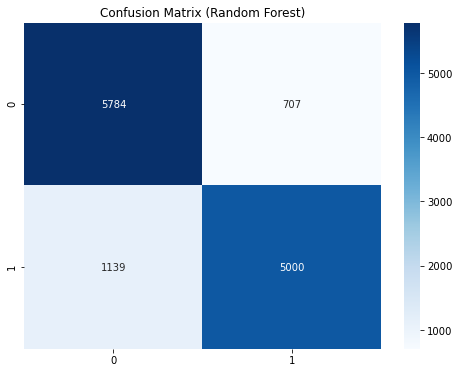

In [39]:
y_pred_df = random_forest.predict(Xval)

#Get the confusion matrix 
cf_matrix = confusion_matrix(Zval, y_pred_df)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(cf_matrix, cmap = 'Blues',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Random Forest)')

## Display the visualization of the Confusion Matrix.
plt.show()

In [40]:
print(classification_report(Zval, y_pred_df))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      6491
           1       0.88      0.81      0.84      6139

    accuracy                           0.85     12630
   macro avg       0.86      0.85      0.85     12630
weighted avg       0.86      0.85      0.85     12630



In [41]:
from sklearn.linear_model import LogisticRegression
# Logistic Regression
# Training
logreg = LogisticRegression()
logreg.fit(train, target)
acc_log = round(logreg.score(train, target) * 100, 2)
acc_log

71.32

In [42]:
# Logistic Regression
# Testing
acc_test_log = round(logreg.score(test, target_test) * 100, 2)
acc_test_log

70.85

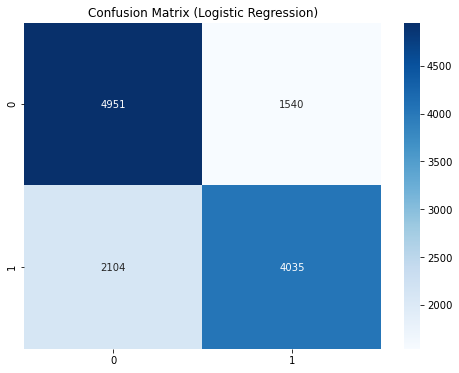

In [43]:
y_pred_lr = logreg.predict(Xval)

#Get the confusion matrix 
cf_matrix = confusion_matrix(Zval, y_pred_lr)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(cf_matrix, cmap = 'Blues',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Logistic Regression)')

## Display the visualization of the Confusion Matrix.
plt.show()

In [44]:
print(classification_report(Zval, y_pred_lr))

              precision    recall  f1-score   support

           0       0.70      0.76      0.73      6491
           1       0.72      0.66      0.69      6139

    accuracy                           0.71     12630
   macro avg       0.71      0.71      0.71     12630
weighted avg       0.71      0.71      0.71     12630



In [45]:
from pycaret.classification import *

clf1 = setup(data = df_clusters, 
             target = 'cardio',
             preprocess = False,
             silent = True)

,Description,Value
0,session_id,8490
1,Target,cardio
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(60142, 10)"
5,Missing Values,False
6,Numeric Features,1
7,Categorical Features,8
8,Transformed Train Set,"(42099, 9)"
9,Transformed Test Set,"(18043, 9)"


In [46]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [47]:
top5 = compare_models(sort='AUC',
                    n_select = 5,
                 )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8425,0.9271,0.8058,0.8635,0.8336,0.6845,0.6860,0.2200
et,Extra Trees Classifier,0.8411,0.9217,0.7989,0.8661,0.8312,0.6815,0.6836,0.2120
dt,Decision Tree Classifier,0.8406,0.9206,0.7964,0.8672,0.8303,0.6806,0.6828,0.0660
gbc,Gradient Boosting Classifier,0.8325,0.9182,0.8003,0.8491,0.8239,0.6645,0.6656,0.2650
ada,Ada Boost Classifier,0.8126,0.9069,0.7969,0.8161,0.8063,0.6248,0.6251,0.8490
knn,K Neighbors Classifier,0.8216,0.8967,0.8079,0.8250,0.8160,0.6430,0.6435,0.4480
qda,Quadratic Discriminant Analysis,0.8056,0.8593,0.7966,0.8045,0.8005,0.6110,0.6111,0.0690
nb,Naive Bayes,0.7116,0.7936,0.5979,0.7619,0.6699,0.4205,0.4303,0.0650
lr,Logistic Regression,0.7120,0.7715,0.6584,0.7275,0.6912,0.4227,0.4245,0.4210
lda,Linear Discriminant Analysis,0.7117,0.7714,0.6495,0.7316,0.6880,0.4218,0.4245,0.0670


In [48]:
stack_model = stack_models(estimator_list = top5, meta_model = top5[0],optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8428,0.9279,0.8094,0.8612,0.8345,0.6850,0.6862
1,0.8439,0.9295,0.8088,0.8637,0.8354,0.6873,0.6887
2,0.8397,0.9277,0.8113,0.8539,0.8320,0.6789,0.6797
3,0.8430,0.9293,0.8171,0.8557,0.8359,0.6856,0.6862
4,0.8390,0.9271,0.8132,0.8512,0.8318,0.6775,0.6781
5,0.8435,0.9290,0.8079,0.8636,0.8348,0.6864,0.6878
6,0.8501,0.9371,0.8278,0.8607,0.8439,0.6999,0.7004
7,0.8584,0.9372,0.8234,0.8797,0.8506,0.7164,0.7178
8,0.8392,0.9242,0.8011,0.8608,0.8299,0.6778,0.6794


In [49]:
blend_soft = blend_models(estimator_list = top5, optimize = 'AUC',method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8418,0.9265,0.8046,0.8632,0.8328,0.6830,0.6846
1,0.8456,0.9282,0.8016,0.8727,0.8356,0.6906,0.6928
2,0.8390,0.9251,0.8035,0.8585,0.8301,0.6773,0.6787
3,0.8392,0.9281,0.8083,0.8552,0.8311,0.6779,0.6789
4,0.8375,0.9274,0.8035,0.8558,0.8288,0.6745,0.6757
5,0.8461,0.9307,0.8059,0.8701,0.8368,0.6916,0.6934
6,0.8523,0.9356,0.8132,0.8761,0.8435,0.7039,0.7057
7,0.8580,0.9350,0.8205,0.8812,0.8497,0.7154,0.7170
8,0.8397,0.9232,0.7899,0.8706,0.8283,0.6786,0.6814


In [50]:
blend_hard = blend_models(estimator_list = top5, optimize = 'AUC',method = 'hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8392,0.0000,0.8094,0.8546,0.8314,0.6779,0.6788
1,0.8439,0.0000,0.7991,0.8714,0.8337,0.6872,0.6895
2,0.8371,0.0000,0.7996,0.8579,0.8277,0.6735,0.6750
3,0.8366,0.0000,0.8040,0.8537,0.8281,0.6726,0.6737
4,0.8371,0.0000,0.8035,0.8549,0.8284,0.6736,0.6747
5,0.8458,0.0000,0.8093,0.8669,0.8371,0.6911,0.6926
6,0.8513,0.0000,0.8122,0.8751,0.8425,0.7020,0.7038
7,0.8556,0.0000,0.8180,0.8786,0.8472,0.7106,0.7123
8,0.8354,0.0000,0.7846,0.8666,0.8235,0.6700,0.6729


In [51]:
#prediction
pred = blend_soft.predict(test)
#Accuracy
confusion_hard = confusion_matrix(target_test, pred)
accuracy = accuracy_score(target_test , pred)
precision = precision_score(target_test , pred)
recall = recall_score(target_test , pred)
f1 = f1_score(target_test,pred) 
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

accuracy: 0.8540, precision: 0.8743, recall: 0.8189,F1: 0.8457


In [52]:
#prediction
pred = stack_model.predict(test)
#Accuracy
confusion_hard = confusion_matrix(target_test, pred)
accuracy = accuracy_score(target_test , pred)
precision = precision_score(target_test , pred)
recall = recall_score(target_test , pred)
f1 = f1_score(target_test,pred) 
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

accuracy: 0.8475, precision: 0.8768, recall: 0.8002,F1: 0.8368


In [53]:
#prediction
pred = blend_hard.predict(test)
#Accuracy
confusion_hard = confusion_matrix( target_test, pred)
accuracy = accuracy_score(target_test , pred)
precision = precision_score(target_test , pred)
recall = recall_score(target_test , pred)
f1 = f1_score(target_test,pred) 
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

accuracy: 0.8534, precision: 0.8747, recall: 0.8169,F1: 0.8448


In [54]:
final_model = finalize_model(stack_model)

In [55]:
#prediction
pred = final_model.predict(test)
#Accuracy
confusion_hard = confusion_matrix(target_test, pred)
accuracy = accuracy_score(target_test, pred)
precision = precision_score(target_test, pred)
recall = recall_score(target_test, pred)
f1 = f1_score(target_test, pred) 
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

accuracy: 0.8485, precision: 0.8706, recall: 0.8103,F1: 0.8394


In [56]:
#prediction
pred = final_model.predict(Xval)
#Accuracy
confusion_hard = confusion_matrix( Zval, pred)
accuracy = accuracy_score(Zval , pred)
precision = precision_score(Zval , pred)
recall = recall_score(Zval , pred)
f1 = f1_score(Zval,pred) 
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

accuracy: 0.8469, precision: 0.8725, recall: 0.8022,F1: 0.8359


Text(0.5, 1.0, 'Confusion Matrix (final_model)')

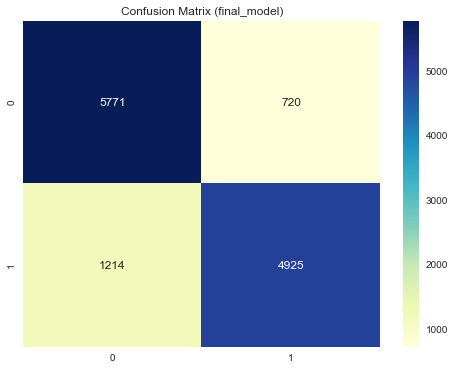

In [57]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_hard, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (final_model)')